In [2]:
import numpy as np 
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load datasets
test=pd.read_csv('test.csv')
test.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [5]:
df=pd.read_csv("training.csv")
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
# sadness(0),joy(1),love(2),anger(3),fear(4),lazy(5)
df['label'].value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [7]:
df['text'][6]

'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny'

In [8]:
# Display basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


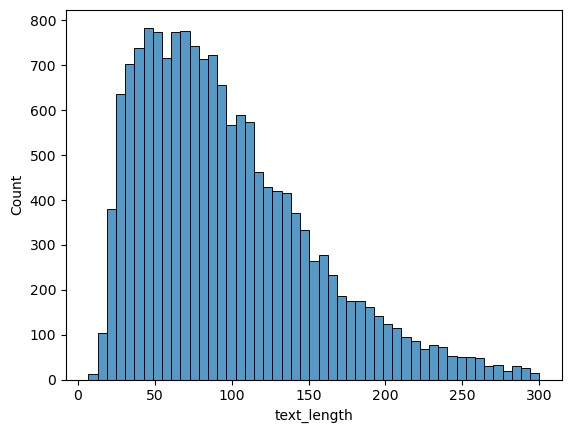

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
df['text_length'] = df['text'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
# Visualize the distribution of text lengths
sns.histplot(df['text_length'])
plt.show()

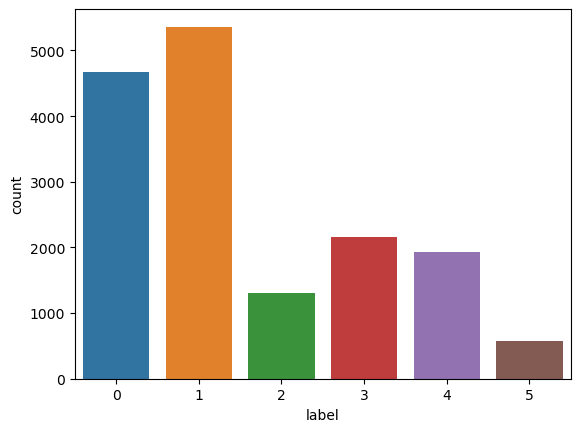

In [10]:
# Visualize the distribution of labels
sns.countplot(x='label', data=df)
plt.show()

In [11]:
import re # regular expression library
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
def normalize(text):
    # Replace with whitespace to separate '😃\n\nFor'
    text = text.replace(r"\n", r" ")
    text = text.replace(r"\r", r" ")
    # Drop puntuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces from '😃  For' to '😃 For'
    text = re.sub(r"\s+", r" ", text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #lower case the all capital alphabets
    text=text.lower()
    stop_words = set(stopwords.words('english'))
    word_tokens=word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    return text

df['text'] = df['text'].apply(lambda x: normalize(x))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SINISTER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SINISTER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# Apply normalization to the text data
test['text']=test['text'].apply(lambda x: normalize(x))

In [13]:
import keras

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [15]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [16]:
# Pad sequences
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)
word_index = tokenizer.word_index
num_words = len(word_index) + 1

In [18]:
# Define LSTM model
model = Sequential()
model.add(Embedding(num_words, 100, input_length=max_length))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 35, 100)             │       1,506,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 35, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,624,222 (6.20 MB)

 Trainable params: 1,624,222 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
model.fit(padded_sequences, pd.get_dummies(df['label']).values, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.3552 - loss: 1.5781 - val_accuracy: 0.7256 - val_loss: 0.8858
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.7748 - loss: 0.6957 - val_accuracy: 0.8994 - val_loss: 0.2992
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.9207 - loss: 0.2457 - val_accuracy: 0.9209 - val_loss: 0.2140
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.9541 - loss: 0.1427 - val_accuracy: 0.9234 - val_loss: 0.2106
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step - accuracy: 0.9635 - loss: 0.1087 - val_accuracy: 0.9247 - val_loss: 0.2083
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.9724 - loss: 0.0800 - val_accuracy: 0.9184 - val_loss: 0.2315
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step - accuracy: 0.9780 - loss: 0.0665 - val_accuracy: 0.9269 - val_loss: 0.2200
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9764 - loss: 0.0620 - 

In [20]:
# Prepare test data
test_sequences = tokenizer.texts_to_sequences(test['text'])
X_test_padded = pad_sequences(test_sequences, maxlen=max_length)  # Adjust maxlen based on your model

# Make predictions using the trained model
predictions = model.predict(X_test_padded)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


In [21]:
predicted_classes = np.argmax(predictions, axis=1)

In [22]:
predicted_classes

array([0, 0, 0, ..., 1, 1, 5], dtype=int64)

In [23]:
# Evaluate the model
score=model.evaluate(X_test_padded,pd.get_dummies(test['label']).values,verbose=0)

In [24]:
print("Accuracy_Acheieved(Test) :",score[1]*100,"%")

Accuracy_Acheieved(Test) : 92.35000014305115 %


In [25]:
# Save the model
model.save("text_based_emotion_classifier.h5")